In [4]:
pip install scikit-image

  Using cached scikit_image-0.24.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached imageio-2.34.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp311-cp311-win_amd64.whl (12.8 MB)
Using cached imageio-2.34.2-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [19]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    images = []
    labels_list = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Warning: Unable to read image {img_path}.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels_list.append(class_num)
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")

    images = np.array(images)
    labels_list = np.array(labels_list)

    return images, labels_list

In [20]:
train_images, train_labels = get_data("chest_xray/chest_xray/train/")
test_images, test_labels = get_data("chest_xray/chest_xray/test")
val_images, val_labels = get_data("chest_xray/chest_xray/val")

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Val images shape: {val_images.shape}")
print(f"Val labels shape: {val_labels.shape}")

Train images shape: (5212, 150, 150)
Train labels shape: (5212,)
Test images shape: (624, 150, 150)
Test labels shape: (624,)
Val images shape: (16, 150, 150)
Val labels shape: (16,)


<Axes: xlabel='count'>

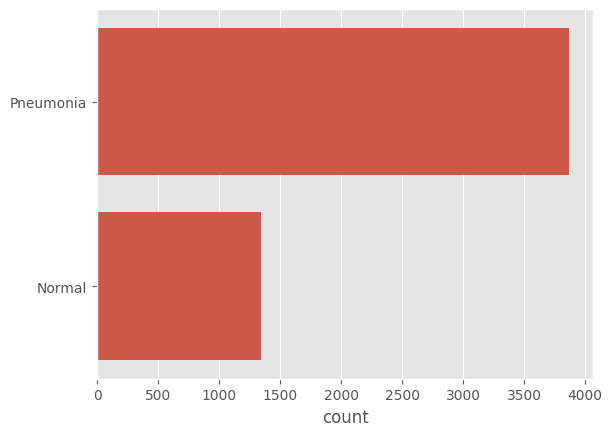

In [21]:
listx = []
for label in train_labels:
    if label == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [23]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5212 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [25]:
class_labels = train_generator.class_indices


In [26]:
class_labels


{'NORMAL': 0, 'PNEUMONIA': 1}

In [27]:
class_name = {value:key for (key, value) in class_labels.items()}

In [11]:
class_name


{0: 'NORMAL', 1: 'PNEUMONIA'}

In [28]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [31]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [32]:
history_001 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=20, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7254 - loss: 0.6126 - val_accuracy: 0.5000 - val_loss: 0.8460 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 955ms/step - accuracy: 0.7323 - loss: 0.5982 - val_accuracy: 0.5000 - val_loss: 0.8478 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7613 - loss: 0.5585 - val_accuracy: 0.5000 - val_loss: 0.8333 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 35s 962ms/step - accuracy: 0.7252 - loss: 0.5807

c:\Users\Suraj\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.7222 - loss: 0.5921 - val_accuracy: 0.5000 - val_loss: 0.8161 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 988ms/step - accuracy: 0.7247 - loss: 0.5816 - val_accuracy: 0.5000 - val_loss: 0.7922 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7399 - loss: 0.5517 - val_accuracy: 0.5000 - val_loss: 0.7681 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 970ms/step - accuracy: 0.7567 - loss: 0.5364 - val_accuracy: 0.5000 - val_loss: 0.7897 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.7478 - loss: 0.5183 - val_accuracy: 0.5000 - val_loss: 0.8003 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 936ms/step - accuracy: 0.7389 - loss: 0.5394 - val_accuracy: 0.5000 - val_loss: 0.7761 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 960ms/step - accuracy: 0.7250

In [40]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [41]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [44]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.5625 - loss: 0.6802
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 819ms/step - accuracy: 0.6789 - loss: 0.5862


In [45]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.68024080991745
Validation Accuarcy: 0.5625
Test Loss: 0.586022675037384
Test Accuarcy: 0.6858974099159241


In [46]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [47]:
base_model_layer_names

['input_layer_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [49]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

c:\Users\Suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [50]:
history_002 = model_02.fit(train_generator, 
            steps_per_epoch=10,
            epochs=20, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7692 - loss: 0.4435 - val_accuracy: 0.5625 - val_loss: 0.6730 - learning_rate: 1.0000e-04
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7395 - loss: 0.4758 - val_accuracy: 0.5625 - val_loss: 0.6562 - learning_rate: 1.0000e-04
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8027 - loss: 0.4202 - val_accuracy: 0.6875 - val_loss: 0.6444 - learning_rate: 1.0000e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7543 - loss: 0.4764 - val_accuracy: 0.6875 - val_loss: 0.6396 - learning_rate: 1.0000e-04
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7784 - loss: 0.4588 - val_accuracy: 0.6875 - val_loss: 0.6386 - learning_rate: 1.0000e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7362 - loss: 0.4877 - val_accuracy: 0.6875 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7577 - loss:

In [51]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [52]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - accuracy: 0.6875 - loss: 0.6266
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 804ms/step - accuracy: 0.7250 - loss: 0.5326
Validation Loss: 0.6265983581542969
Validation Accuarcy: 0.6875
Test Loss: 0.5311727523803711
Test Accuarcy: 0.7371794581413269


In [53]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

c:\Users\Suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [59]:
history_03 = model_03.fit(train_generator, 
            steps_per_epoch=100,
            epochs=15, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.7709 - loss: 0.4679 - val_accuracy: 0.6875 - val_loss: 0.6291 - learning_rate: 1.0000e-04
Epoch 2/15
 63/100 ━━━━━━━━━━━━━━━━━━━━ 3:09 5s/step - accuracy: 0.8130 - loss: 0.4407

c:\Users\Suraj\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.8113 - loss: 0.4353 - val_accuracy: 0.6875 - val_loss: 0.5903 - learning_rate: 1.0000e-04
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - accuracy: 0.8163 - loss: 0.4026 - val_accuracy: 0.6875 - val_loss: 0.5752 - learning_rate: 1.0000e-04
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8311 - loss: 0.3742 - val_accuracy: 0.7500 - val_loss: 0.5165 - learning_rate: 1.0000e-04
Epoch 4: early stopping
